# Classical AE Notebook - Elias Michael

## Replicate Batson et al.'s Results for Baseline

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torch.utils.data import DataLoader, TensorDataset

### Data Generation

In [2]:
# Generate a circle with 1000 uniformly sampled dots
def generate_circle(n_samples=1000):
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    x = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    return x.astype(np.float32), theta.astype(np.float32)

In [3]:
# Generate a sphere with 3000 uniformly sampled dots
def generate_sphere(n_samples=3000):
    phi = np.random.uniform(0, 2 * np.pi, n_samples)
    costheta = np.random.uniform(-1, 1, n_samples)
    theta = np.arccos(costheta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.stack([x, y, z], axis=1).astype(np.float32)

### Batson's AE Architecture

In [4]:
# Batson AE Model Definition
class BatsonAE(nn.Module):
    def __init__(self, d_in, d_latent, d_width=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, d_width),
            nn.Tanh(),
            nn.Linear(d_width, d_latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_latent, d_width),
            nn.Tanh(),
            nn.Linear(d_width, d_in),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

### Training Routine

In [5]:
# Using Batson's Hyperparameters
def train_autoencoder(model, data, epochs=20000, batch_size=64, lr=0.01):
    dataset = TensorDataset(torch.tensor(data))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        for (x,) in loader:
            optimizer.zero_grad()
            out, _ = model(x)
            loss = loss_fn(out, x)
            loss.backward()
            optimizer.step()
        if epoch % 1000 == 0:
            print(f"[SGD] Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

### Visuals

#### Circle

In [6]:
# Reconstruction Plot
def plot_reconstruction(model, data):
    with torch.no_grad():
        x = torch.tensor(data)
        x_recon, _ = model(x)
        x = x.numpy()
        x_recon = x_recon.numpy()

    # Overlayed
    plt.figure(figsize=(7, 7))
    plt.scatter(x[:, 0], x[:, 1], s=8, alpha=0.5, label='Original', edgecolor='k')
    plt.scatter(x_recon[:, 0], x_recon[:, 1], s=8, alpha=0.5, label='Reconstruction', marker='x', color='crimson')
    plt.legend(fontsize=12)
    plt.title("Original vs Reconstruction (S¹)", fontsize=14)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [7]:
# Other plots from Batson's paper
def plot_phi_metrics(model, data, phi):
    with torch.no_grad():
        x = torch.tensor(data)
        x_recon, z = model(x)
        x_recon = x_recon.numpy()
        z = z.numpy().flatten()
        loss = np.sum((x_recon - data)**2, axis=1)
        log_loss = np.log(loss + 1e-8)  # avoid log(0)

    # Identify φ₀ (location of max loss)
    phi0 = phi[np.argmax(loss)]

    # Latent representation as a function of input φ
    plt.figure(figsize=(8, 5))
    plt.scatter(phi, z, s=10, alpha=0.7)
    plt.axvline(phi0, color='red', linestyle='--', linewidth=1.5, label=f'φ₀ ≈ {phi0:.2f}')
    plt.xlabel("Input φ", fontsize=12)
    plt.ylabel("Latent Coordinate", fontsize=12)
    plt.title("Latent Representation vs Input φ", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Model φ as a function of input φ
    phi_recon = np.arctan2(x_recon[:, 1], x_recon[:, 0])
    plt.figure(figsize=(8, 5))
    plt.scatter(phi, phi_recon, s=10, alpha=0.7)
    plt.axvline(phi0, color='red', linestyle='--', linewidth=1.5, label=f'φ₀ ≈ {phi0:.2f}')
    plt.xlabel("Input φ", fontsize=12)
    plt.ylabel("Output φ", fontsize=12)
    plt.title("Output φ vs Input φ", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Loss as a function of input φ
    plt.figure(figsize=(8, 5))
    plt.scatter(phi, log_loss, s=10, alpha=0.7)
    plt.axvline(phi0, color='red', linestyle='--', linewidth=1.5, label=f'φ₀ ≈ {phi0:.2f}')
    plt.xlabel("Input φ", fontsize=12)
    plt.ylabel("Log Reconstruction Loss", fontsize=12)
    plt.title("Log(Loss) vs Input φ", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Sphere

In [8]:
# Sphere Plots
def plot_sphere_reconstruction(model, data):
    with torch.no_grad():
        x = torch.tensor(data)
        x_recon, _ = model(x)
        x = x.numpy()
        x_recon = x_recon.numpy()
        loss = np.sum((x_recon - x)**2, axis=1)
        log_loss = np.log(loss + 1e-8)

    # Autoencoder Output - Reconstuction Plot
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_recon[:, 0], x_recon[:, 1], x_recon[:, 2], s=3, alpha=0.5)
    ax.set_title("Autoencoder Output (S²)")
    plt.tight_layout()
    plt.show()

    # Mollweide colored by log loss
    theta = np.arccos(x[:, 2])
    phi = np.arctan2(x[:, 1], x[:, 0])
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='mollweide')
    sc = ax.scatter(phi, np.pi/2 - theta, c=log_loss, cmap='coolwarm', s=6)
    cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.07, shrink=0.7, aspect=25)
    cb.set_label("Log Reconstruction Loss", fontsize=11)
    ax.set_title("Test Set Colored by Log Loss (Mollweide)", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    # Log Loss vs Distance
    idx_max = np.argmax(loss)
    anchor = x[idx_max]
    dist = np.linalg.norm(x - anchor, axis=1)
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(dist, log_loss, s=5, alpha=0.7)
    plt.xlabel("Distance from Max-Loss Point")
    plt.ylabel("Log Reconstruction Loss")
    plt.title("Log(Loss) vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Execution Block

[SGD] Epoch 0, Loss: 0.299810
[SGD] Epoch 1000, Loss: 0.059980
[SGD] Epoch 2000, Loss: 0.055801
[SGD] Epoch 3000, Loss: 0.043165
[SGD] Epoch 4000, Loss: 0.082200
[SGD] Epoch 5000, Loss: 0.008834
[SGD] Epoch 6000, Loss: 0.001963
[SGD] Epoch 7000, Loss: 0.051976
[SGD] Epoch 8000, Loss: 0.006392
[SGD] Epoch 9000, Loss: 0.083608
[SGD] Epoch 10000, Loss: 0.001104
[SGD] Epoch 11000, Loss: 0.050425
[SGD] Epoch 12000, Loss: 0.003201
[SGD] Epoch 13000, Loss: 0.003162
[SGD] Epoch 14000, Loss: 0.003081
[SGD] Epoch 15000, Loss: 0.001270
[SGD] Epoch 16000, Loss: 0.066736
[SGD] Epoch 17000, Loss: 0.019002
[SGD] Epoch 18000, Loss: 0.000630
[SGD] Epoch 19000, Loss: 0.001241


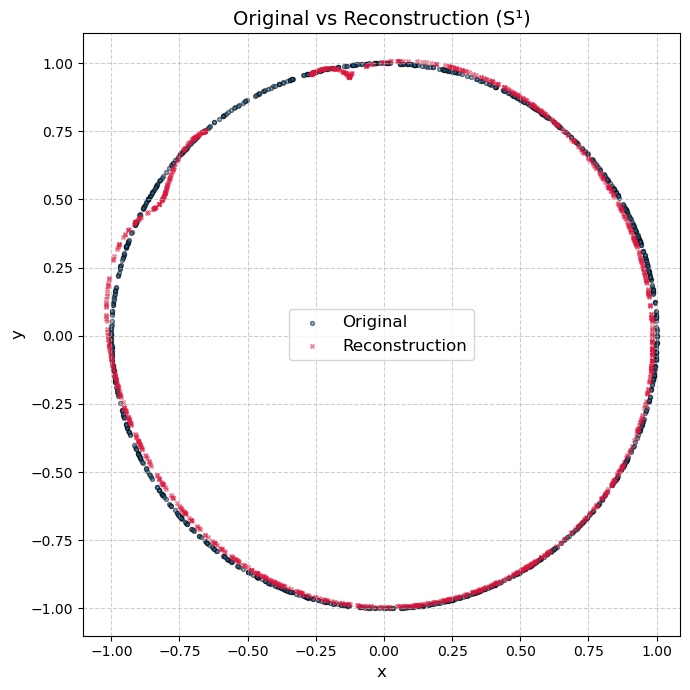

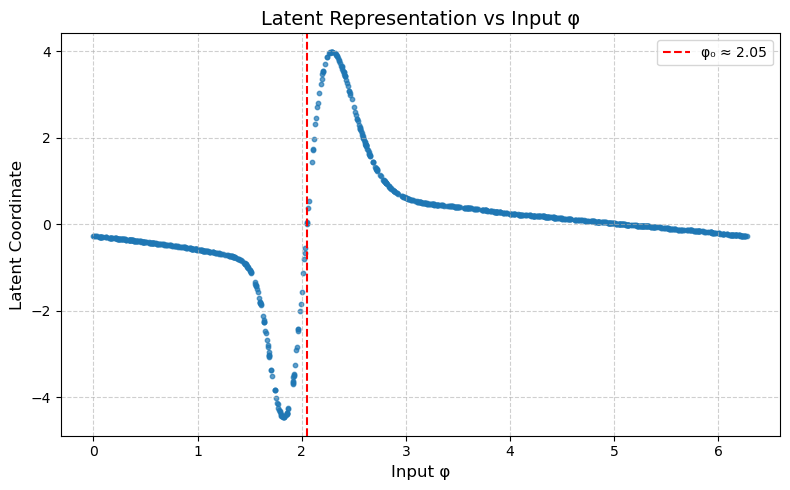

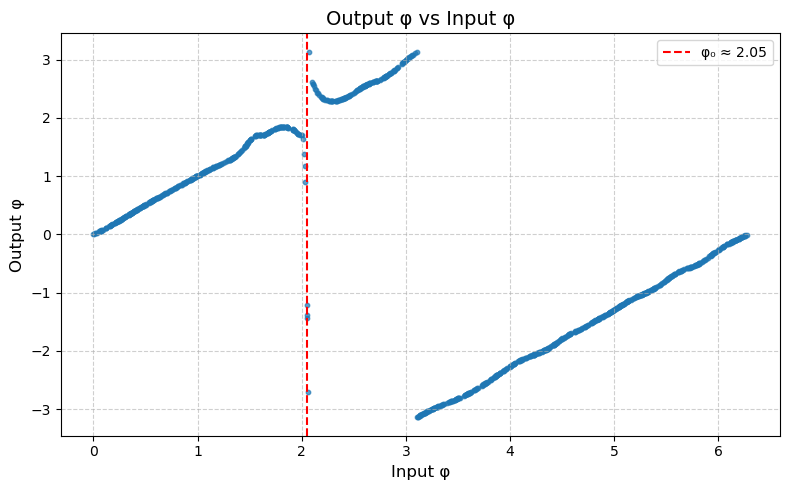

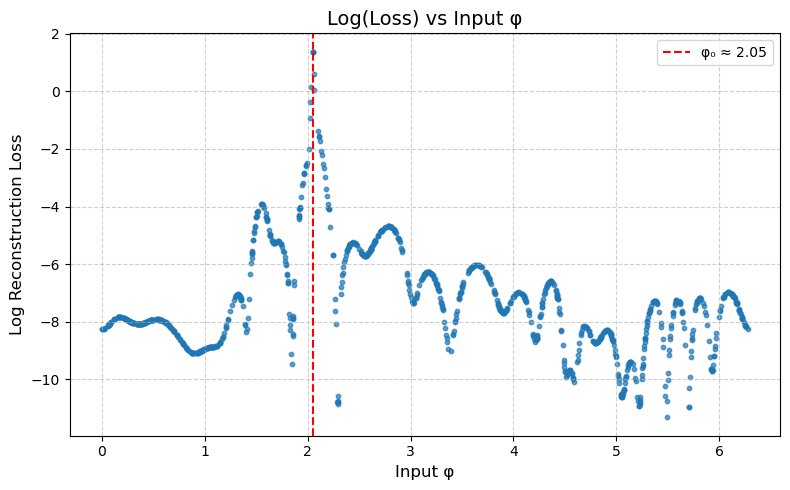

[SGD] Epoch 0, Loss: 0.247272
[SGD] Epoch 1000, Loss: 0.103816
[SGD] Epoch 2000, Loss: 0.019992
[SGD] Epoch 3000, Loss: 0.017339
[SGD] Epoch 4000, Loss: 0.004382
[SGD] Epoch 5000, Loss: 0.013231
[SGD] Epoch 6000, Loss: 0.003449
[SGD] Epoch 7000, Loss: 0.002351
[SGD] Epoch 8000, Loss: 0.009425
[SGD] Epoch 9000, Loss: 0.017760
[SGD] Epoch 10000, Loss: 0.006444
[SGD] Epoch 11000, Loss: 0.001876
[SGD] Epoch 12000, Loss: 0.001892
[SGD] Epoch 13000, Loss: 0.002772
[SGD] Epoch 14000, Loss: 0.008227
[SGD] Epoch 15000, Loss: 0.011638
[SGD] Epoch 16000, Loss: 0.001088
[SGD] Epoch 17000, Loss: 0.001119
[SGD] Epoch 18000, Loss: 0.002279
[SGD] Epoch 19000, Loss: 0.004049


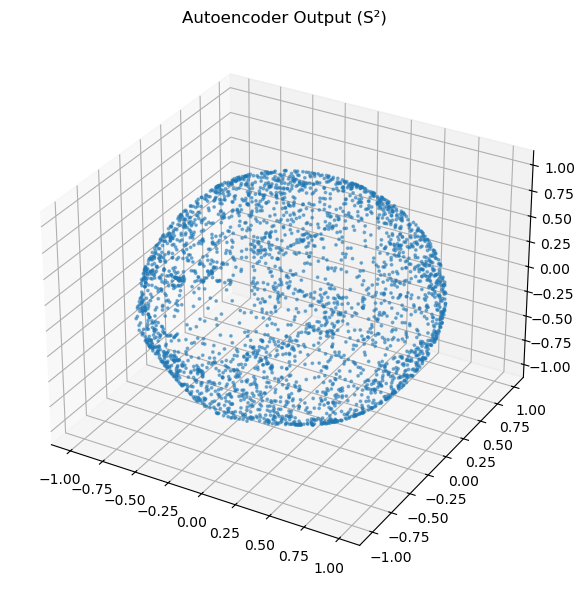

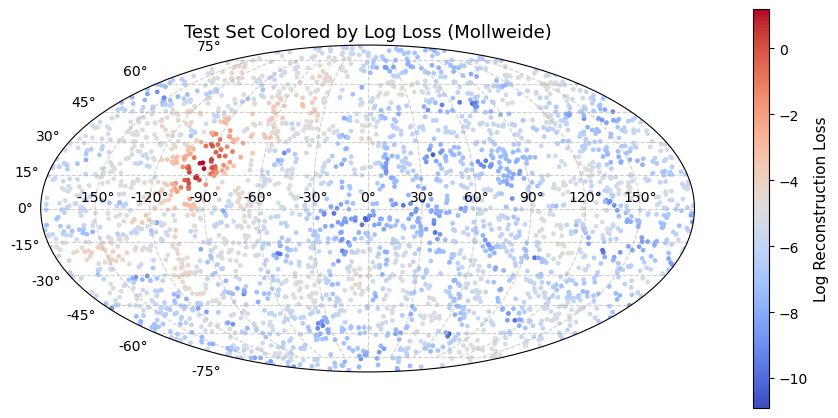

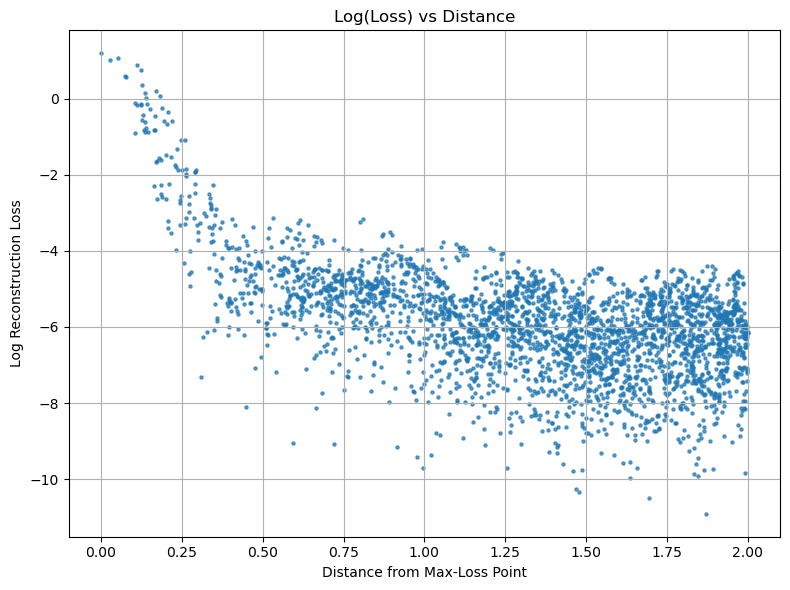

In [9]:
# Running the functions for replicating Batson's results
if __name__ == "__main__":
    # --- Circle (S¹) ---
    # Generate train/test data from S¹
    s1_train, s1_phi_train = generate_circle(1000)
    s1_test, s1_phi = generate_circle(1000)

    # Initialize & train AE
    model_s1 = BatsonAE(d_in=2, d_latent=1)
    model_s1 = train_autoencoder(model_s1, s1_train)

    # Visualize the plots
    plot_reconstruction(model_s1, s1_test)
    plot_phi_metrics(model_s1, s1_test, s1_phi)

    # --- Sphere (S²) ---
    # Generate train/test data from S²
    s2_train = generate_sphere(3000)
    s2_test = generate_sphere(3000)

    # Initialize & train AE
    model_s2 = BatsonAE(d_in=3, d_latent=2)
    model_s2 = train_autoencoder(model_s2, s2_train)

    # Visualize the plots
    plot_sphere_reconstruction(model_s2, s2_test)